In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from scipy import stats
from torchsummaryX import summary

In [2]:
#Define hyperparameter
split_ratio = 0.70
num_epochs = 200
window_size = 4
batch_size = 10

# hidden layer for LSTM
hidden_dim = 64

In [3]:
power = pd.read_csv('preprocessed_data.csv')

In [4]:
# skip this line if yours is total_power_consumption
power = power.rename(columns = {'total power consumption' : 'total_power_consumption'})
power.head()

,date,holiday,total_power_consumption,temp_mean
0,2011-11-23,0,90.39,8.46
1,2011-11-24,0,213.41,10.12
2,2011-11-25,0,303.99,8.48
3,2011-11-26,0,420.98,12.28
4,2011-11-27,0,444.88,7.42


In [5]:
# remove holiday and temp_mean
power.drop(['holiday', 'temp_mean'], axis=1, inplace=True)
power.head()

,date,total_power_consumption
0,2011-11-23,90.39
1,2011-11-24,213.41
2,2011-11-25,303.99
3,2011-11-26,420.98
4,2011-11-27,444.88


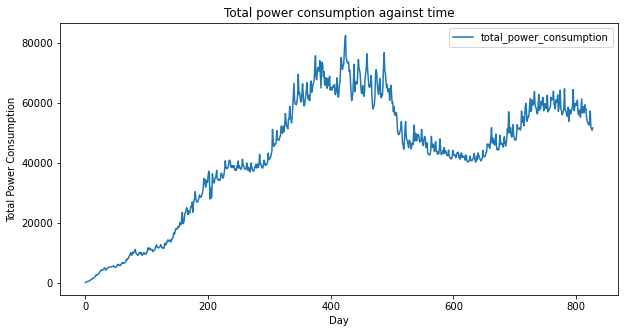

In [6]:
power.plot(figsize=(10,5))
plt.xlabel("Day")
plt.ylabel("Total Power Consumption")
plt.title("Total power consumption against time")
plt.show()

In [7]:
#remove the last data point (because the last data point suddenly drop)
power = power.iloc[:-1]

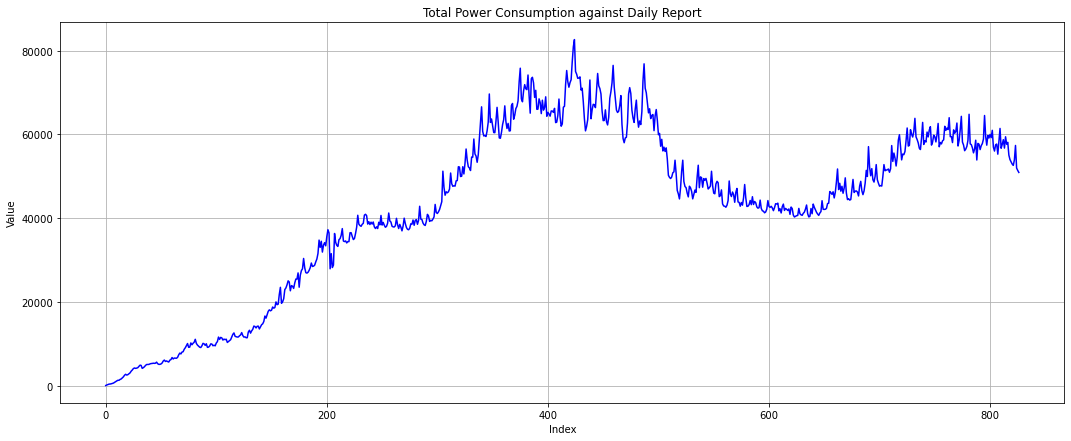

In [8]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Total Power Consumption against Daily Report")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    power['total_power_consumption'],
    color='blue', label='Data');

In [9]:
power_ts = power.set_index(power['date'])
power_ts.head()

,date,total_power_consumption
date,,
2011-11-23,2011-11-23,90.39
2011-11-24,2011-11-24,213.41
2011-11-25,2011-11-25,303.99
2011-11-26,2011-11-26,420.98
2011-11-27,2011-11-27,444.88


In [10]:
power_ts = pd.Series(power_ts['total_power_consumption'])
power_ts.head()

date
2011-11-23     90.39
2011-11-24    213.41
2011-11-25    303.99
2011-11-26    420.98
2011-11-27    444.88
Name: total_power_consumption, dtype: float64

Text(0.5, 1.0, 'Time Series plot')

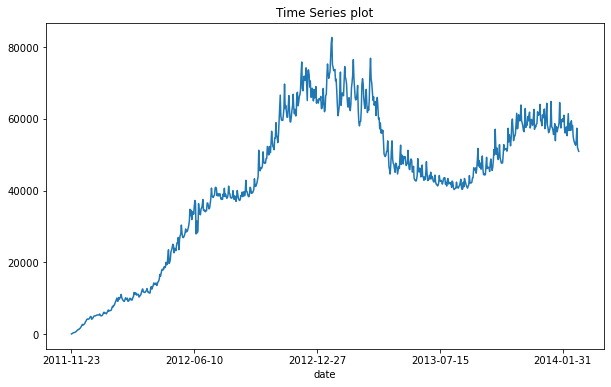

In [11]:
plt.figure(figsize=(10,6))
power_ts.plot()
plt.title("Time Series plot")

### Split Data

In [88]:
#Split data by indexing
split_data_power = round(len(power_ts)*split_ratio)
split_data_power

579

In [13]:
#Data Splitting
train_data_power = power_ts[:split_data_power]
test_data_power = power_ts[split_data_power:]
train_time_power = train_data_power.index
test_time_power = test_data_power.index

### Data Standardization

In [14]:
scaler_power = StandardScaler().fit(train_data_power.values.reshape(-1,1))
scaler_train_power_data = scaler_power.transform(train_data_power.values.reshape(-1,1))
scaler_test_power_data = scaler_power.transform(test_data_power.values.reshape(-1,1))

### Data Sequencing

In [15]:
# Data sequencing function
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [16]:
trainX_power, trainY_power = univariate_single_step(scaler_train_power_data, window_size)
testX_power, testY_power = univariate_single_step(scaler_test_power_data, window_size)

print(f"trainX shape:{trainX_power.shape} trainY shape:{trainY_power.shape}\n")
print(f"testX shape:{testX_power.shape} testX shape:{testY_power.shape}")

trainX shape:(575, 4, 1) trainY shape:(575, 1)

testX shape:(244, 4, 1) testX shape:(244, 1)


### Data Transform

Transform the data from ndarray to torch tensor

In [17]:
# Transform numpy to Pytorch tensor
trainX_power = torch.from_numpy(trainX_power).type(torch.Tensor)
trainY_power = torch.from_numpy(trainY_power).type(torch.Tensor)
testX_power = torch.from_numpy(testX_power).type(torch.Tensor)
testY_power = torch.from_numpy(testY_power).type(torch.Tensor)

print(f"trainX shape:{trainX_power.shape} trainY shape:{trainY_power.shape}\n")
print(f"testX shape:{testX_power.shape} testY shape:{testY_power.shape}")

trainX shape:torch.Size([575, 4, 1]) trainY shape:torch.Size([575, 1])

testX shape:torch.Size([244, 4, 1]) testY shape:torch.Size([244, 1])


### Data Transform

Create data iterator to enable the data to be stored in batches

In [18]:
# Create Iterator

train_dataset_power = TensorDataset(trainX_power, trainY_power)
train_iter_power = DataLoader(train_dataset_power,batch_size = batch_size, shuffle=False)

test_dataset_power = TensorDataset(testX_power, testY_power)
test_iter_power = DataLoader(test_dataset_power, batch_size= batch_size, shuffle=False)

### LSTM Model Configuration

Create model configuration for both Vanilla LSTM and Bidirectional LSTM

In [19]:
#Vanilla LSTM
class LSTM(nn.Module):
    
    def __init__(self, n_feature, hidden_dim, num_layers, n_step) :
        super(LSTM, self).__init__()
        self.n_feature = n_feature
        
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.num_layers = num_layers
        
        self.n_step = n_step
        
        #Building your LSTM
        # batch_first =True
        #Configuration -> (number of feature, number of hidden unit, number of layer)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)
        
        #Readout Layer
        self.fc = nn.Linear(hidden_dim, n_step)
        
    def forward(self, x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        
        #Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # we just want last time step hidden states(output)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out
        

In [20]:
# Bidirectional LSTM
class BidirectionalLSTM(nn.Module):
    
    def __init__(self, n_feature, hidden_dim, num_layers, n_step):
        super(BidirectionalLSTM, self).__init__()
        
        # Number of feature of data
        self.n_feature = n_feature
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.num_layers = num_layers
        
        # Number of step, step =1 -> single step forecast
        self.n_step = n_step
        
        # Building your LSTM
        # batch_first = True
        # Configuration -> (number of feature, number of hidden unit, number of layer)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, n_step)
        
    def forward(self, x):
        #Initialize hidden state with zeros 
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)
        
        #Initalize cell state with zeros
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        
        #Index hidden state of last time step
        out = self.fc(out)
        
        return out
        
        

### Input Model 

Feel free to use any type of LSTM. Save the model with name `model_power`

In [21]:
# Arguments for LSTM model

torch.manual_seed(123)

number_of_time_series = 1
time_step = 1
n_step =1

# num layers :1 for vanila LSTM, >1 is mean stacked LSTM
num_layers = 1

# Vanilla, Stacked LSTM
model_power = LSTM(n_feature=number_of_time_series, hidden_dim = hidden_dim, num_layers=num_layers, n_step =n_step)

# Bidirectional LSTM
# model_power = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim = hidden_dim, num_layers=num_layers, n_step =n_step)

Use `MSELoss` as the loss and `Adam` as the optimizer. 
Save MSELoss into variable name `loss_fn_power` and `Adam` optimizer into `optimizer_power`

In [22]:
# Define MSE as loss function
loss_fn_power = torch.nn.MSELoss()

# Set up optimizer
optimizer_power = torch.optim.Adam(model_power.parameters(), lr=0.001)

### Training

Write training function that will fit the data to the model

In [23]:
torch.manual_seed(123)
def training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cummulative sum
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for _,(train_X, train_Y) in enumerate(train_iter):
            
            # Forward pass
            y_train_pred = model(train_X)
            
            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)
            
            # Zero out gradient, else they will accumulate between batches 
            optimizer.zero_grad()
            
            # Backward pass
            loss_train.backward()
            
            # Update parameters 
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0)
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size, train_iter.dataset is use to get total batch size
        epoch_loss_train = running_loss_train / len(train_iter.dataset)
        
        #Store the averaged value
        train_loss[t] = epoch_loss_train
        
        #Validate the test data loss
        with torch.no_grad():
            # For loop to loop thorugh each data in the data iterator
            for j, (test_X, test_Y) in enumerate (test_iter):
                y_test_pred = model(test_X)
                
                # Reshape to ensure the predicted output (y_test_grad) same size with test_y shape
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()* test_X.size(0)
                
            # Average the loss base on total batch size
            epoch_loss_test = running_loss_valid /len(test_iter.dataset)
            
            # Store the averaged value 
            val_loss[t] = epoch_loss_test
            
        
    return train_loss, val_loss     

In [24]:
# Start Training
train_loss_power , val_loss_power = training(num_epochs, train_iter_power, test_iter_power, optimizer_power, loss_fn_power, model_power)

### Validation

A train loss and val loss is plotted to define how well the data fits the model

In [25]:
def learning_curve(num_epochs, train_loss, val_loss):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Train Loss & Test Loss")
    plt.show()
    for i in range(num_epochs):
        print(f'Epoch : {i} , training loss : {train_loss[i]}, validation loss : {val_loss[i]}')
        

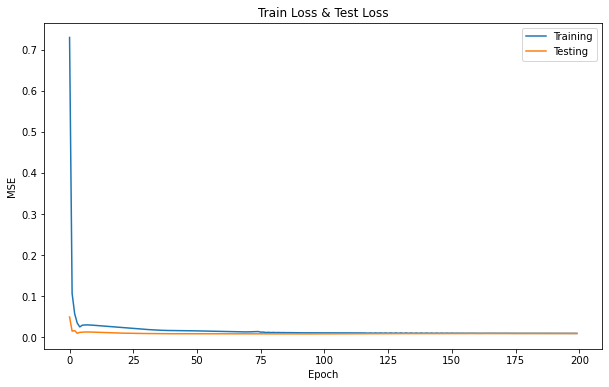

Epoch : 0 , training loss : 0.7295953081920743, validation loss : 0.04925539077175629
Epoch : 1 , training loss : 0.10657082408180703, validation loss : 0.014842663878254348
Epoch : 2 , training loss : 0.05733204637856587, validation loss : 0.01609229271636024
Epoch : 3 , training loss : 0.034571375196759145, validation loss : 0.009621117498771455
Epoch : 4 , training loss : 0.025105690128048478, validation loss : 0.011774113279629926
Epoch : 5 , training loss : 0.02923854434579287, validation loss : 0.012223958835524858
Epoch : 6 , training loss : 0.029801949124236633, validation loss : 0.01265432911955553
Epoch : 7 , training loss : 0.029988212820203246, validation loss : 0.01274984184133469
Epoch : 8 , training loss : 0.029758996217835534, validation loss : 0.012631801514290884
Epoch : 9 , training loss : 0.02932232454844305, validation loss : 0.012402473029024044
Epoch : 10 , training loss : 0.0288233101023766, validation loss : 0.012133829612437575
Epoch : 11 , training loss : 0.0

In [26]:
learning_curve(num_epochs, train_loss_power, val_loss_power)

In [27]:
# Zoom in by fill in start_epoch and end_epoch
def zoom_learning_curve(start_epoch, end_epoch, training_loss, validation_loss):
    plt.figure(figsize=(10,6))
    plt.plot(training_loss[start_epoch:end_epoch], label="Training loss")
    plt.plot(validation_loss[start_epoch:end_epoch], label="Testing loss")
    plt.title("Losses")
    plt.xlabel("Epoch_Demand")
    plt.ylabel("MSE_Demand")
    position = range(end_epoch-start_epoch)
    labels = range(start_epoch, end_epoch)
    plt.xticks(position, labels)
    plt.legend()

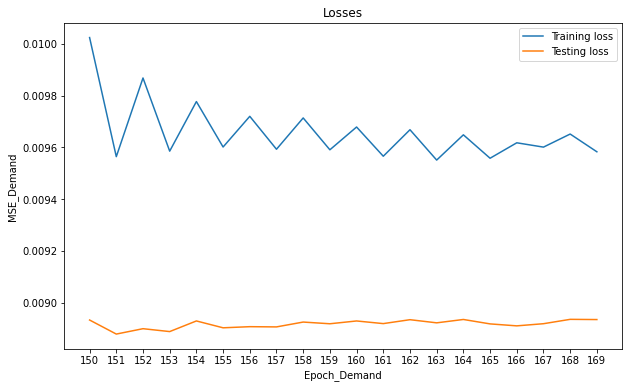

In [28]:
# Zoom in to visualize the graph by fill in start_epoch and end_epoch that want to analyse
zoom_learning_curve(start_epoch=150, end_epoch=170, training_loss = train_loss_power, validation_loss=val_loss_power)

### Evaluation

This section is to inference the model by feeding in testing data, determining the output forecast value and calculating the RMSE

In [29]:
# Section 1 : Make predictions
with torch.no_grad():
    y_train_prediction_power = model_power(trainX_power)
    y_test_prediction_power = model_power(testX_power)
    
# Section 2 : Reshape to original data    
y_train_prediction_power = torch.reshape(y_train_prediction_power,(y_train_prediction_power.shape[0], y_train_prediction_power.shape[1]))
trainY_power = torch.reshape(trainY_power, (trainY_power.shape[0], trainY_power.shape[1]))
y_test_prediction_power = torch.reshape(y_test_prediction_power,(y_test_prediction_power.shape[0],y_test_prediction_power.shape[1]))
testY_power = torch.reshape(testY_power,(testY_power.shape[0],testY_power.shape[1]))

In [30]:
# Section 3 : Invert predictions

y_train_pred_power = scaler_power.inverse_transform(y_train_prediction_power)
y_train_power = scaler_power.inverse_transform(trainY_power)
y_test_pred_power = scaler_power.inverse_transform(y_test_prediction_power)
y_test_power = scaler_power.inverse_transform(testY_power)

In [31]:
print("y-test\t\ty-predict")
for i in range(len(y_test_power)):
    print(f"{y_test_power[i]}\t\t{y_test_pred_power[i]}")

y-test		y-predict
[44240.87]		[43546.31]
[43248.41]		[44383.566]
[45147.13]		[43484.094]
[43296.24]		[45288.84]
[44011.51]		[43531.477]
[43704.18]		[44297.914]
[42716.34]		[43951.777]
[42417.83]		[43065.176]
[42522.76]		[42820.613]
[44335.07]		[42867.176]
[42360.64]		[44460.582]
[41787.02]		[42645.035]
[41692.41]		[42259.926]
[41310.23]		[42133.92]
[41510.43]		[41730.516]
[42184.63]		[41897.2]
[44223.86]		[42473.086]
[42817.29]		[44289.406]
[42604.4]		[43019.12]
[42858.96]		[42969.098]
[42464.65]		[43180.62]
[41817.81]		[42782.145]
[42544.01]		[42221.07]
[43476.16]		[42867.72]
[43396.918]		[43649.344]
[43609.26]		[43578.21]
[41762.48]		[43832.473]
[42269.87]		[42191.79]
[41272.62]		[42688.82]
[42765.64]		[41711.39]
[43384.08]		[43042.355]
[41870.5]		[43530.895]
[42351.03]		[42218.285]
[42139.06]		[42735.055]
[41868.87]		[42479.066]
[42222.88]		[42233.688]
[40935.21]		[42553.75]
[42674.85]		[41391.113]
[42316.67]		[42966.723]
[40768.55]		[42563.152]
[40310.16]		[41253.895]
[40482.32]		[

In [123]:
train_date = pd.date_range(start='2011-11-01', end='2013-06-23')
train = pd.DataFrame(train_data_power)
test_date = pd.to_datetime(pd.date_range(start='2013-06-24', end='2014-02-22', freq='D'),unit = 'D')
test = pd.DataFrame(y_test_power, index = test_date, columns = ['test']) 
forecast = pd.DataFrame(y_test_pred_power, index = test_date, columns = ['forecast'])

In [124]:
df = pd.concat([train, test, forecast], axis=1).reset_index()
df = df.rename(columns={"total_power_consumption": "train"})
df

,index,train,test,forecast
0,2011-11-23,90.39,NaN,NaN
1,2011-11-24,213.41,NaN,NaN
2,2011-11-25,303.99,NaN,NaN
3,2011-11-26,420.98,NaN,NaN
4,2011-11-27,444.88,NaN,NaN
...,...,...,...,...
818,2014-02-18 00:00:00,NaN,53945.871094,53026.589844
819,2014-02-19 00:00:00,NaN,57379.089844,54269.765625
820,2014-02-20 00:00:00,NaN,51994.550781,57504.246094
821,2014-02-21 00:00:00,NaN,51423.507812,52033.066406


In [125]:
# train.to_csv('train.csv')
# test.to_csv('test.csv')
# forecast.to_csv('forecast.csv')
df.to_csv('forecast.csv')

In [121]:
# Section 4 : Calculate root mean squared error for both train and test data

trainScore_power = math.sqrt(mean_squared_error(y_train_power, y_train_pred_power))
print('Train Score: %.2f RMSE' % (trainScore_power))
testScore_power = math.sqrt(mean_squared_error(y_test_power, y_test_pred_power))
print('Test Score: %.2f RMSE' % (testScore_power))

Train Score: 2077.84 RMSE
Test Score: 2147.68 RMSE


### Forecast Plot

Use `single_step_plot` function to plot the forecasted result

In [40]:
def single_step_plot(original_test_data,sequence_test_data,forecast_data,test_time,window_size,original_plot =False):
    # Take the time index after data sequence
    sequence_test_time = test_time[window_size:]
    
    plt.figure(figsize=(10,6))
    
    if original_plot:
        plt.plot(test_time,original_test_data,color="blue",label = 'Test Data')
        
    plt.plot(sequence_test_time,sequence_test_data,color="green", label = 'Test Data After Sequence')
    plt.plot(sequence_test_time,forecast_data,color="red", label = 'Forecast')
    plt.xticks(rotation = 45)
    plt.ylabel("Value")
    plt.title("Forecast plot")
    plt.legend()

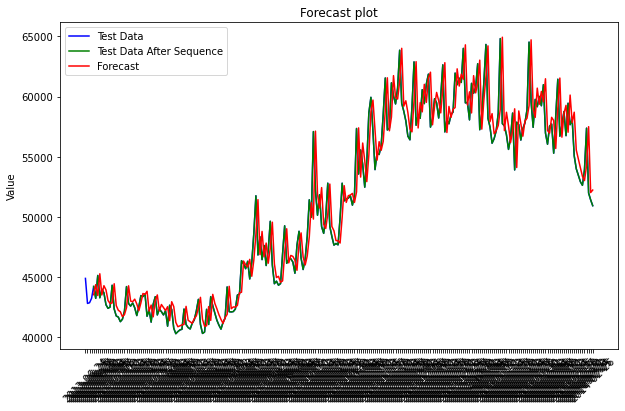

In [41]:
single_step_plot(original_test_data = test_data_power,
                 sequence_test_data = y_test_power,
                 forecast_data = y_test_pred_power,
                 test_time = test_time_power,
                 window_size = window_size,
                 original_plot = True )